## Exercise from Aurelien Hands On Machine Learning 

Dataset from Kaggle: https://www.kaggle.com/camnugent/california-housing-prices

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('C:/Users/yarkh/Desktop/CS/datasets/housing.csv')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
X = df.drop(['median_house_value'], axis=1).values
y = df['median_house_value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Remove correlated features
 (Total bedrooms, Population, Households)

2. Transform into bell shape
 (Total rooms, Median income)

3. Impute outliers
 (Median for numerical, Most frequent for categorical)

4. Encode

5. Scale

6. Parameter tuning with cross validation

In [40]:
class AddDropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #Do transformations
        room_per_household = X[:,3] / X[:,6]
        popul_per_household = X[:,5] / X[:,6]
        X = np.c_[X, room_per_household] # Add features
        X = np.c_[X, popul_per_household]
        X = X[:, [0,1,2,3,7,8,9,10]] # Drop features
        
        return X
    
class Center(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for index in self.columns:
            X[:, index] = X[:, index]**0.5
        
        return X
    
class MarkOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Store thresholds
        self.thresholds = dict()
        for index in self.columns:
            tmp = X[:,index]
            iqr_ = iqr(tmp)
            upper = np.percentile(tmp, 75) + 2 * iqr_
            lower = np.percentile(tmp, 25) - 2 * iqr_
            
            self.thresholds[index] = [0, 0]
            self.thresholds[index][0] = lower
            self.thresholds[index][1] = upper

        return self

    def transform(self, X):
        #Do transformations
        for index, bounds in self.thresholds.items():
            lower = bounds[0]
            upper = bounds[1]
            tmp = X[:,index]
            tmp[(tmp > upper) | (tmp < lower)] = np.nan
            X[:,index] = tmp
            
        return X
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Do transformations           
        return X[:, self.features].reshape(-1, len(self.features))
    
class CustomBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.lb = LabelBinarizer()
        self.lb.fit(X)
        return self
    
    def transform(self, X):
        #Do transformations           
        return self.lb.transform(X)
    
    
## Total_rooms, median_income sqrt
## Outlier remove for total_rooms, popul_per, room_per

In [53]:
num_pipeline = Pipeline([
    ("feature_selector", FeatureSelector([0,1,2,3,4,6,7])),
    ("simpleImputer", SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ("feature_selector", FeatureSelector([5])),
    ("simpleImputer", SimpleImputer(strategy='most_frequent')),
    ("binarizer", CustomBinarizer())
])

union = FeatureUnion([
    ("num_pipeline" , num_pipeline),
    ("cat_pipeline", cat_pipeline)
])
    
finalPipeline = Pipeline([
    ("addDrop", AddDropFeatures()),
    ("center", Center([3,4])),
    ("markOutliers", MarkOutliers([3,6,7])),
    ("union", union),
    ("standardScaler", StandardScaler()),
    ("svr", SVR(kernel="poly", coef0=1, degree=4, C= 10000, epsilon=0.1))
])

In [54]:
finalPipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('addDrop', AddDropFeatures()),
                ('center', Center(columns=[3, 4])),
                ('markOutliers', MarkOutliers(columns=[3, 6, 7])),
                ('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('num_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('feature_selector',
                                                                  FeatureSelector(features=[0,
                                                                                            1,
                                                                                            2,
                                                                                            3,
                                                                                            4,
                                             

In [55]:
y_pred = finalPipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mse

3112961092.591649

In [56]:
mse**0.5

55793.916268636756

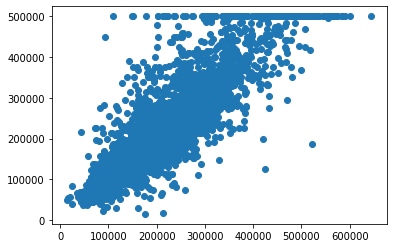

In [59]:
plt.scatter(y_pred, y_test)

In [60]:
# param_grid = {
#     'svr__degree' : [1,23,4],
#     'svr__C' : [0.01, 0.1, 1, 10, 100, 1000],
#     'svr__epsilon': [0.05, 0.1, 1],
#     'svr__coef0': [0, 0.1, 1]
# }

# grid = GridSearchCV(finalPipeline, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2)
# grid.fit(X_train, y_train)

In [38]:
# grid.best_params_

{'svr__C': 1000, 'svr__coef0': 1, 'svr__degree': 4, 'svr__epsilon': 0.1}